## 1. 사용할 패키지 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import L1Loss
import json
from data_gen.data_gen import DatasetGenerator
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from tqdm import tqdm

## 2. 데이터 불러오기

### (0) 압축파일 풀기

In [3]:
%cd /content
!unzip -qq "/content/drive/MyDrive/크몽/221113 번호판인식.zip"

/content
replace data_gen/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### (1) 이미지 및 Json 파일 리스트 불러오기

In [2]:
train_img_dir = './dataset/train/img'
train_json_dir = './dataset/train/json'
test_img_dir = './dataset/test/img'
test_json_dir = './dataset/test/json'

In [3]:
train_img_list = os.listdir(train_img_dir)
train_img_list = sorted(train_img_list)
train_img_list = [os.path.join(train_img_dir, img) for img in train_img_list]
train_json_list = os.listdir(train_json_dir)
train_json_list = sorted(train_json_list)
train_json_list = [os.path.join(train_json_dir, js) for js in train_json_list]

test_img_list = os.listdir(test_img_dir)
test_img_list = sorted(test_img_list)
test_img_list = [os.path.join(test_img_dir, img) for img in test_img_list]
test_json_list = os.listdir(test_json_dir)
test_json_list = sorted(test_json_list)
test_json_list = [os.path.join(test_json_dir, js) for js in test_json_list]

print("Train Image 개수: {}".format(len(train_img_list)))
print("Test Image 개수: {}".format(len(test_img_list)))

Train Image 개수: 574
Test Image 개수: 5


## 3. 모델링

### (1) Dataloader 생성

In [4]:
train_dataset = DatasetGenerator(train_img_list, train_json_list, batch_size = 16, phase = 'train')
train_dataloader = train_dataset.dataloader()
test_dataset = DatasetGenerator(test_img_list, test_json_list, batch_size = 1, phase = 'test')
test_dataloader = test_dataset.dataloader()                 

### (2) Model 생성

In [5]:
model_name = 'resnet18'

In [6]:
# build model
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, 8)

### (3) 학습 파라미터 지정

In [7]:
epoch = 30
learning_rate = 0.001
weight_decay = 0.0001
result_dir = './result/'
os.makedirs(result_dir, exist_ok = True)

### (4) Loss, Optimizer 생성

In [17]:
# get loss function from LossFactory
loss_fn = L1Loss()

# get optimizer from OptimizerFactory
optimizer = Adam(params = vision_model.parameters(),
                lr=learning_rate,
                weight_decay = weight_decay)

### (5) 학습

In [9]:
print("{} start training!".format(model_name))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vision_model.to(device)
min_valid_loss = np.inf

# training
for e in range(epoch):
    train_loss = 0.0
    vision_model.train()     # Optional when not using Model Specific layer
    for data in tqdm(train_dataloader['train']):
        if torch.cuda.is_available():
            images, labels = data['image'].float().to(device), data['target'].float().to(device)
        
        optimizer.zero_grad()
        target = vision_model(images)
        loss = loss_fn(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(images)
            
    valid_loss = 0.0
    vision_model.eval()     # Optional when not using Model Specific layer
    for data in tqdm(test_dataloader['test']):
        if torch.cuda.is_available():
            data, labels = data['image'].float().to(device), data['target'].float().to(device)
        
        target = vision_model(data)
        loss = loss_fn(target,labels)
        valid_loss = loss.item() * len(data)

    print("Epoch: {}, Training Loss: {}, Test Loss: {}".format(e+1, train_loss / len(train_dataloader['train']), valid_loss))   
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(vision_model.state_dict(), result_dir + 'Best_model.pth')    

resnet18 start training!


100%|██████████| 5/5 [00:00<00:00,  9.26it/s]


Epoch: 1, Training Loss: 9.952753301650759, Test Loss: 141.02239990234375
Validation Loss Decreased(inf--->141.022400) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 11.20it/s]


Epoch: 2, Training Loss: 8.299217445509775, Test Loss: 85.25466918945312
Validation Loss Decreased(141.022400--->85.254669) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch: 3, Training Loss: 6.77772819806659, Test Loss: 74.42495727539062
Validation Loss Decreased(85.254669--->74.424957) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch: 4, Training Loss: 5.590911282433404, Test Loss: 64.05475616455078
Validation Loss Decreased(74.424957--->64.054756) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch: 5, Training Loss: 4.7234315115308005, Test Loss: 57.293861389160156
Validation Loss Decreased(64.054756--->57.293861) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch: 6, Training Loss: 4.014851747997223, Test Loss: 46.74403381347656
Validation Loss Decreased(57.293861--->46.744034) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch: 7, Training Loss: 3.2078225404497176, Test Loss: 32.18132019042969
Validation Loss Decreased(46.744034--->32.181320) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch: 8, Training Loss: 2.3118582637537095, Test Loss: 21.24970817565918
Validation Loss Decreased(32.181320--->21.249708) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch: 9, Training Loss: 1.5216709782206823, Test Loss: 23.153507232666016


100%|██████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch: 10, Training Loss: 1.2139125586975188, Test Loss: 11.260640144348145
Validation Loss Decreased(21.249708--->11.260640) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch: 11, Training Loss: 1.0577240697448216, Test Loss: 12.375274658203125


100%|██████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch: 12, Training Loss: 0.9828248728835393, Test Loss: 6.060970306396484
Validation Loss Decreased(11.260640--->6.060970) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch: 13, Training Loss: 0.9093348989411005, Test Loss: 9.891681671142578


100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch: 14, Training Loss: 0.8337742022815204, Test Loss: 7.127590656280518


100%|██████████| 5/5 [00:00<00:00, 16.68it/s]


Epoch: 15, Training Loss: 0.8696215367979474, Test Loss: 6.193408012390137


100%|██████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch: 16, Training Loss: 0.824142075365498, Test Loss: 12.095046043395996


100%|██████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch: 17, Training Loss: 0.774028688196152, Test Loss: 4.773818016052246
Validation Loss Decreased(6.060970--->4.773818) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch: 18, Training Loss: 0.7937809228897095, Test Loss: 4.208148002624512
Validation Loss Decreased(4.773818--->4.208148) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch: 19, Training Loss: 0.731009718917665, Test Loss: 3.607309341430664
Validation Loss Decreased(4.208148--->3.607309) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch: 20, Training Loss: 0.7240132368982785, Test Loss: 3.4656076431274414
Validation Loss Decreased(3.607309--->3.465608) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch: 21, Training Loss: 0.7020616107989871, Test Loss: 3.302515983581543
Validation Loss Decreased(3.465608--->3.302516) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch: 22, Training Loss: 0.6786638160073568, Test Loss: 4.106389045715332


100%|██████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch: 23, Training Loss: 0.6988717633343878, Test Loss: 2.860696792602539
Validation Loss Decreased(3.302516--->2.860697) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch: 24, Training Loss: 0.6304431180395778, Test Loss: 3.6626110076904297


100%|██████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch: 25, Training Loss: 0.6393861419388226, Test Loss: 3.874114990234375


100%|██████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch: 26, Training Loss: 0.6233046911065541, Test Loss: 5.183826446533203


100%|██████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch: 27, Training Loss: 0.6489282783771319, Test Loss: 3.467456817626953


100%|██████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch: 28, Training Loss: 0.604109133165034, Test Loss: 2.3123655319213867
Validation Loss Decreased(2.860697--->2.312366) 	 Saving The Model


100%|██████████| 5/5 [00:00<00:00, 16.43it/s]


Epoch: 29, Training Loss: 0.6162792465516499, Test Loss: 3.271026611328125


100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch: 30, Training Loss: 0.6103039184023463, Test Loss: 1.7863054275512695
Validation Loss Decreased(2.312366--->1.786305) 	 Saving The Model


### (6) Load Best Model

In [9]:
vision_model.load_state_dict(torch.load('result/Best_model.pth'))

<All keys matched successfully>

### (7) 성능 평가

In [10]:
import matplotlib.pyplot as plt
def plot_prediction(image, target):
    plt.plot([target[0], target[2]], [target[1], target[3]], color="white", linewidth=3)
    plt.plot([target[2], target[6]], [target[3], target[7]], color="white", linewidth=3)
    plt.plot([target[6], target[4]], [target[7], target[5]], color="white", linewidth=3)
    plt.plot([target[4], target[0]], [target[5], target[1]], color="white", linewidth=3)

    plt.imshow(image[0, :, :])
    plt.show()

#### - 정답

Ground Truth


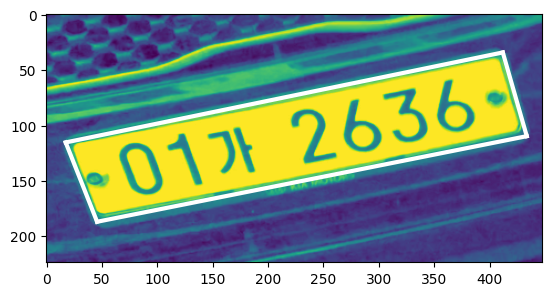

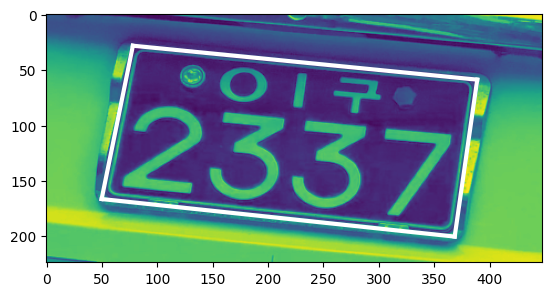

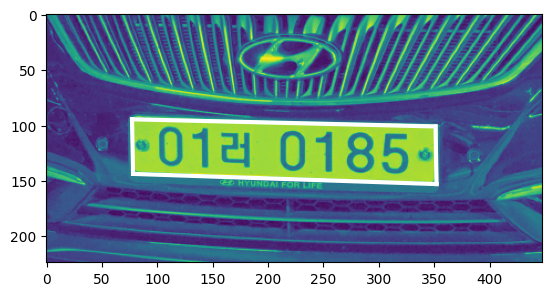

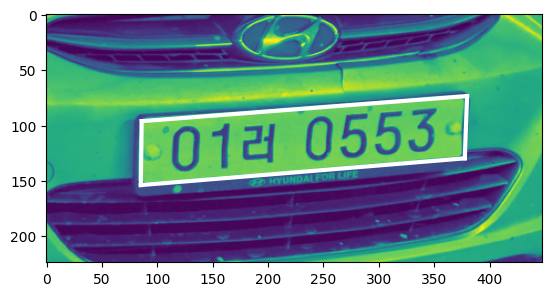

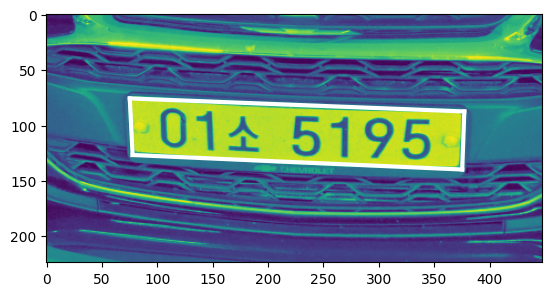

In [12]:
print('Ground Truth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in test_dataloader['test']:
        images, labels = data['image'].float().to(device), data['target'].float().to(device)
        images = images.to(device)  
        labels = labels.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        labels = labels.cpu().numpy()
        images = images.cpu().numpy()
        plot_prediction(images[0, :, :, :], labels[0])

#### - 예측

Prediction


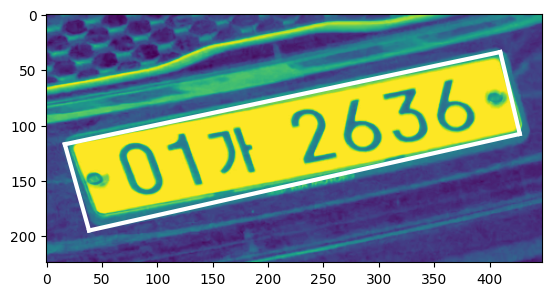

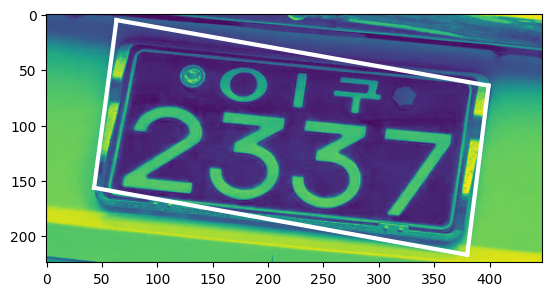

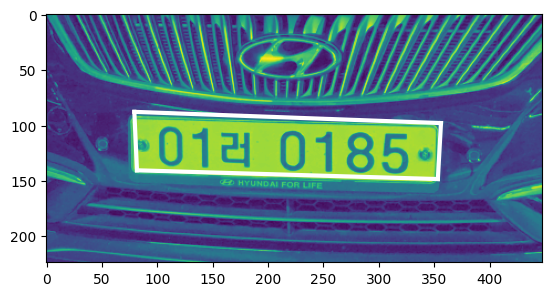

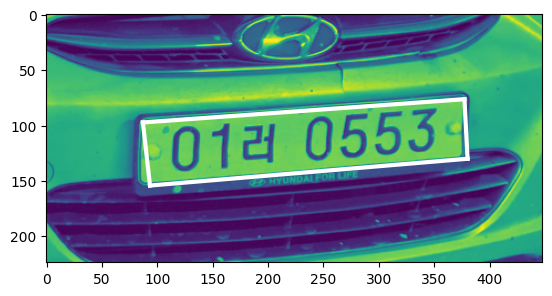

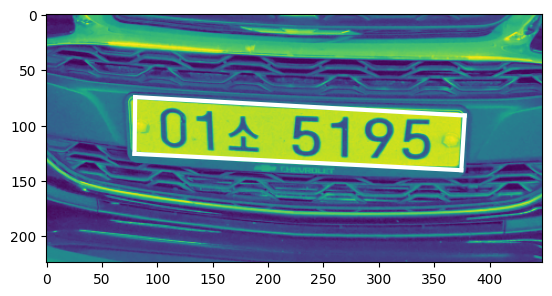

In [13]:
print('Prediction')
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in test_dataloader['test']:
        images, labels = data['image'].float().to(device), data['target'].float().to(device)
        images = images.to(device)  
        labels = labels.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        labels = labels.cpu().numpy()
        images = images.cpu().numpy()
        plot_prediction(images[0, :, :, :], pred[0])

#### - IOU 계산

In [14]:
def iou_calculate(labels, pred):
  img1 = np.zeros((224, 448, 3))
  points = np.array([[round(labels[0][0]), round(labels[0][1])], [round(labels[0][2]), round(labels[0][3])], [round(labels[0][6]), round(labels[0][7])], [round(labels[0][4]), round(labels[0][5])]]).reshape(1, -1, 2)
  cv2.fillPoly(img1, points, color=(0, 1, 0))

  img2 = np.zeros((224, 448, 3))
  points = np.array([[round(pred[0][0]), round(pred[0][1])], [round(pred[0][2]), round(pred[0][3])], [round(pred[0][6]), round(pred[0][7])], [round(pred[0][4]), round(pred[0][5])]]).reshape(1, -1, 2)
  cv2.fillPoly(img2, points, color=(0, 1, 0))

  iou = np.sum(img1 + img2 == 2) / np.sum(img1)
  return iou

In [15]:
print('Calculation IOU')
predictions = []
iou_list = []
vision_model.to(device)

with torch.no_grad():  
    for data in test_dataloader['test']:
        images, labels = data['image'].float().to(device), data['target'].float().to(device)
        images = images.to(device)  
        labels = labels.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        labels = labels.cpu().numpy()
        iou_list.append(iou_calculate(labels, pred))

print("Test IOU: {}".format(np.mean(iou_list)))

Calculation IOU
Test IOU: 0.9534223042268952
